In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from pytz import timezone

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show, plot_events_data
from utils.optimization import MyOptimizationProblem, convert_to_model_params, plot_optimization_params, plot_optimization_error, plot_compare, compute_metrics
from utils.data import get_events, get_sections, process_df, export_dataframe_to_latex, load_df as load_df_inner
from utils.sensitivity_analysis import describe_param_with_uniform_distribution, describe_param_with_log_uniform_distribution, describe_param_with_triangular_distribution, describe_param_with_normal_distribution, describe_param_with_truncated_normal_distribution, describe_param_with_log_normal_distribution, wrapped_model_function, create_problem_spec_and_sample, plot_sampled_distribuitions, evaluate_problem, analyze_time_step, analyze_problem, sobol_sensitivity_analysis_from_model_params_to_outputs, plot_sensitivity_analysis, plot_sensitivity_analysis_heatmaps, get_region_mean, plot_sensitivity_analysis_bars

import warnings
warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/'
latex_tex_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/tex/'

# Data

In [4]:
def compute_df_soc(df, nominal_Q, inplace=False):
    """
    Compute the State of Charge (SOC) of a battery.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        inplace (bool, optional): If True, the SOC values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed SOC values as a fraction of the nominal capacity.

    Notes:
        - The input DataFrame `df` is expected to contain a column named 'batt_Q' representing the battery charge.
        - The output SOC values are dimensionless fractions representing the battery's charge level relative to its nominal capacity.
        - If `inplace` is True, the computed SOC values are added as a new column 'batt_z' to the input DataFrame `df`.
    """
    SOC = df['batt_Q'].to_numpy() / nominal_Q

    if inplace:
        df['batt_z'] = SOC
    return SOC

def compute_df_capacity(df, nominal_Q, initial_SOC, inplace=False):
    """
    Compute the capacity of a battery based on cumulative integration of current over time.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        initial_SOC (float): Initial State of Charge (SOC) as a fraction of the nominal capacity.
        inplace (bool, optional): If True, the computed capacity values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed capacity values in Ampere-hours (Ah).

    Notes:
        - The input DataFrame `df` is expected to contain columns 'batt_i' for battery current and 't' for time.
        - The output capacity values represent the remaining battery capacity after cumulative integration of current over time.
        - The input parameter `initial_SOC` is a dimensionless fraction representing the initial battery charge relative to its nominal capacity.
        - If `inplace` is True, the computed capacity values are added as a new column 'batt_Q' to the input DataFrame `df`.
    """
    from scipy.integrate import cumulative_trapezoid as cumtrapz

    time_hours = df['t'] / 3600.0  # Converts time in seconds to time in hours
    Q = (nominal_Q * initial_SOC) - cumtrapz(df['batt_i'], time_hours, initial=0)  # units: Amper-hour

    if inplace:
        df['batt_Q'] = Q
    return Q

def load_df(filename, start, end, resample_rule, rename_columns, print_columns, iqr_threshold, cutoff_freq, sampling_rate, order, nominal_Q, initial_SOC):
    df = load_df_inner(
        filename=filename,
        start=start,
        end=end,
        resample_rule=resample_rule,
        rename_columns=rename_columns,
        print_columns=print_columns,
        iqr_threshold=iqr_threshold,
        cutoff_freq=cutoff_freq,
        sampling_rate=sampling_rate,
        order=order,
    )

    compute_df_capacity(df, nominal_Q, initial_SOC, inplace=True)
    compute_df_soc(df, nominal_Q, inplace=True)

    return df

cell_amps_hour = 48
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q = parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
initial_SOC = 0.99

Train size ≃ 51.14%
Test size ≃ 48.86%


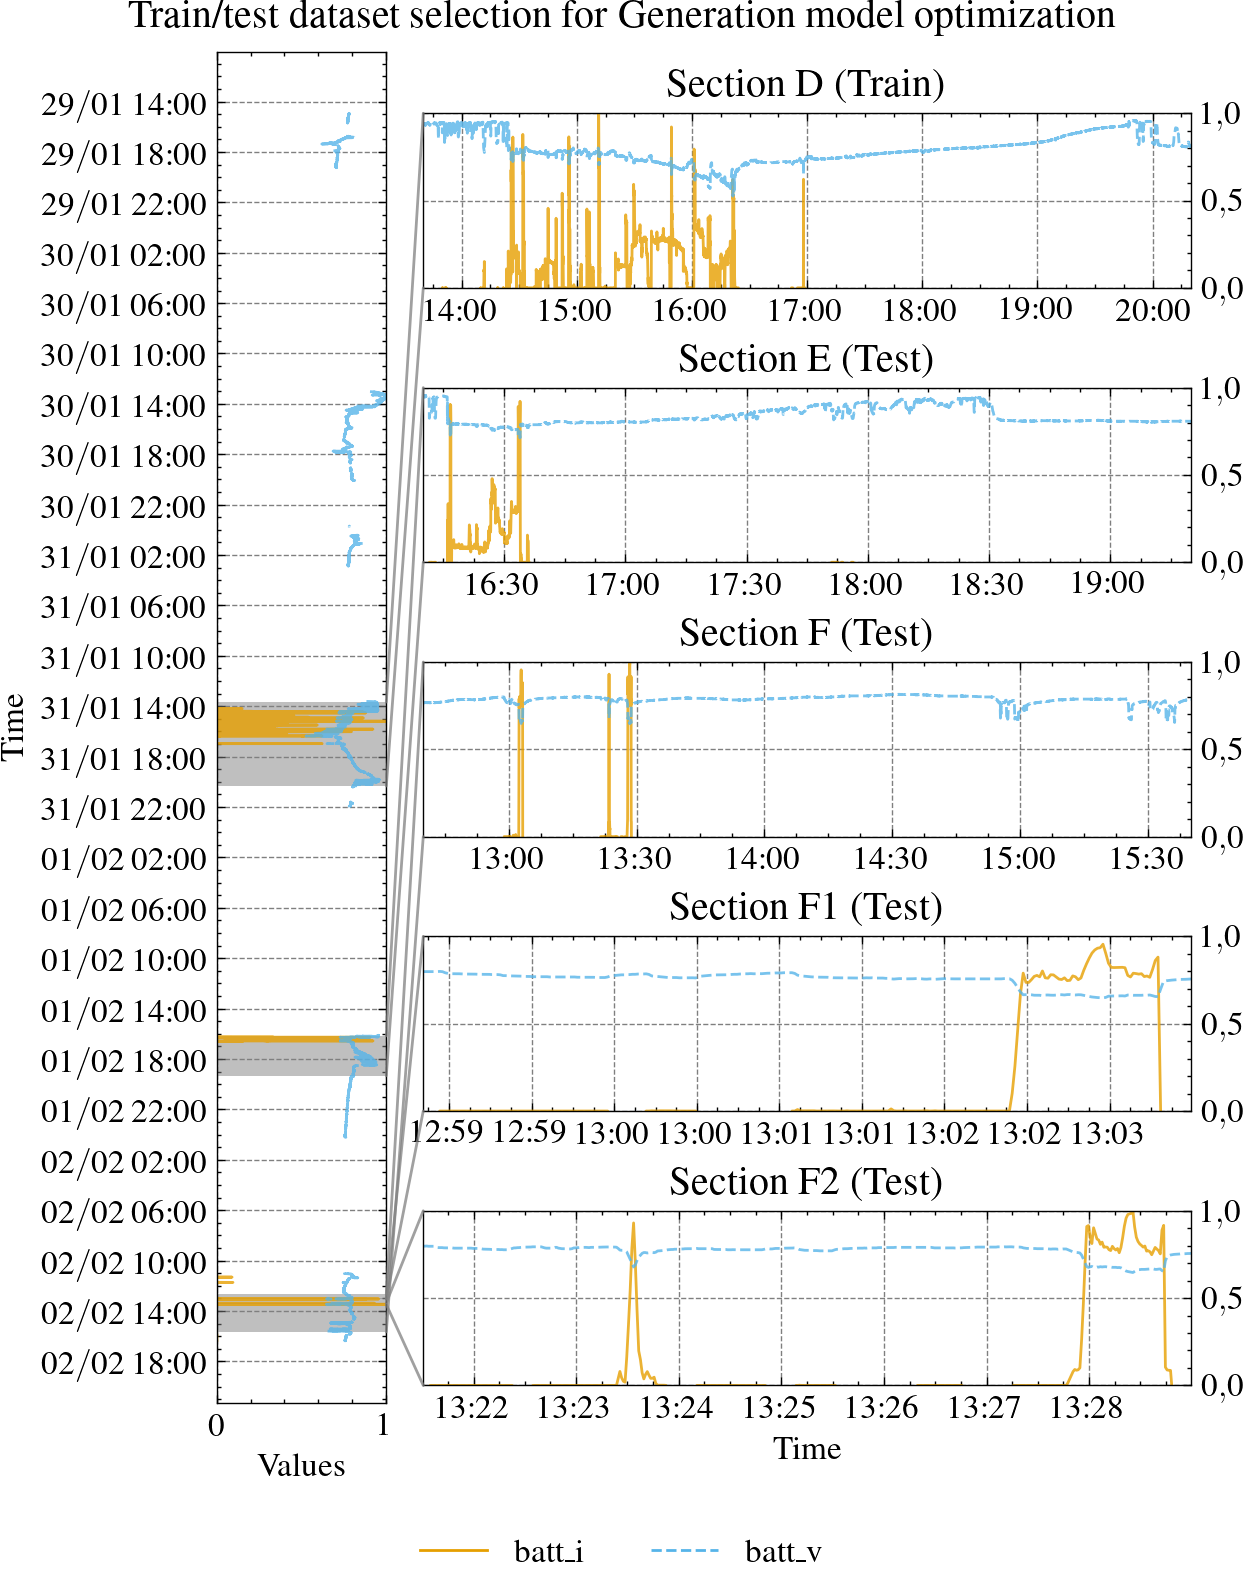

In [ ]:
# filename = "../../../models/2020/boat_data_100ms.csv"
filename = "../../../models/2020/boat_data_1s.csv"
rename_columns = {
    'Battery Pack Voltage': 'batt_v',
    'Battery Current': 'batt_i',
}
df = load_df(
    filename=filename,
    start=None,
    end=None,
    resample_rule=None,
    rename_columns=rename_columns,
    print_columns=False,
    iqr_threshold=None,
    cutoff_freq=None,
    sampling_rate=1,
    order=1,
    nominal_Q=nominal_Q,
    initial_SOC=initial_SOC
)

sections, tzinfo = get_sections()

# Customizing ranges:
# sections.loc['Section D', 'start'] = pd.Timestamp('2020-01-31 14:20:00')
# sections.loc['Section D', 'end'] = pd.Timestamp('2020-01-31 16:20:00')
# sections.loc['Section E', 'end'] = pd.Timestamp('2020-02-01 16:20:00')
sections.loc['Section F1'] = [pd.Timestamp('2020-02-02 12:58:50'), pd.Timestamp('2020-02-02 13:03:30')]
sections.loc['Section F2'] = [pd.Timestamp('2020-02-02 13:21:30'), pd.Timestamp('2020-02-02 13:29:00')]
sections = sections.loc[['Section D', 'Section E', 'Section F', 'Section F1', 'Section F2']]

train_section_name = 'Section D'
train_test_sections = sections.reset_index().to_dict(orient='records')
train_section = sections.loc[sections.index == train_section_name].reset_index().to_dict(orient='records')[0]
test_sections = sections.loc[sections.index != train_section_name].reset_index().to_dict(orient='records')

train_size = 0
test_size = 0
for i in range(len(train_test_sections)):
    if train_test_sections[i]['name'] == train_section_name:
        train_test_sections[i]['name'] = train_test_sections[i]['name'] + ' (Train)'
        train_size += df.loc[(df.index >= train_test_sections[i]['start']) & (df.index <= train_test_sections[i]['end'])].size
    else:
        train_test_sections[i]['name'] = train_test_sections[i]['name'] + ' (Test)'
        test_size += df.loc[(df.index >= train_test_sections[i]['start']) & (df.index <= train_test_sections[i]['end'])].size


total_size = train_size+test_size
print(f'Train size ≃ {100*train_size/total_size:.2f}%')
print(f'Test size ≃ {100*test_size/total_size:.2f}%')

fig_save_and_show(
        filename=None,#f'{latex_img_path}/battery_optimization_test_residuals_{col}.pdf',
        show_title=f'Train/test dataset selection for Generation model optimization',
        save_title=f'Dataset da embarcação durante o DSB de 2019',
        ncol=4,
        fig=plot_events_data(
            events=train_test_sections,
            df=df,
            column_names=['batt_i', 'batt_v'],
            normalize=True,
        )
    )


# Battery Equivalent Circuit Model


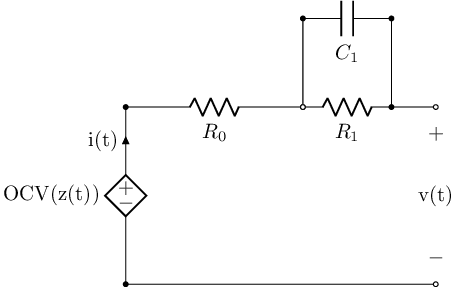

In [6]:
# %pip install lcapy zfitpy pyspice
# %pip install https://github.com/mph-/lcapy/archive/master.zip
# Open `tllocalmgr`, then `install circuitikz`, then `exit`, then `sudo texhash`
import lcapy as lca

circuit_draw_params = dict(
    # help_lines=1,
    # debug=True,
    draw_nodes=True,
    label_nodes=False,
    label_ids=True,
    label_values=False,
    cpt_size=1,
    node_spacing=3,
    scale=1,
    dpi=150,
)

circuit = lca.Circuit("""
E1 R0.1 0 2 0; down, l={OCV(z(t))}, i>={i(t)}
R0 .1 .2; right
R1 R0.2 .2; right=0.5
C1 .1 .2; right=0.5
W R1.1 C1.1; up=0.5
W R1.2 C1.2; up=0.5
W R1.2 P1.1; right=0.25
P1 .1 0_2; down, v={v(t)}
W 0 0_2; right
;""")
circuit.draw(**circuit_draw_params)
circuit.draw(**circuit_draw_params, filename="/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/battery_model.png")


![](feZkCLr.png)

De acordo com [Mateo Basic](https://www.sciencedirect.com/science/article/pii/S2405896322003469), as seguintes equações representam o sistema da imagem acima, onde $z(t)$ é o estado de carga da bateria:

$$ \begin{aligned}
    \frac{dv_{C_{1}}(t) }{ dt } &=
        -\frac{ v_{C_{1}}(t) }{ R_{1} C_{1} }
        +\frac{ i(t) }{ C_{1} } \\
    \frac{ dv_{C_{0}}(t) }{ dt } &=
        \frac{ i(t) }{ C_{0} } \\
    v(t) &= 
        -v_{C_{0}}
        -v_{C_{1}}
        -R_{0} i(t)
\end{aligned} $$

O estado de carga ($z(t)$) pode ser definido como nas equações abaixo, onde $Q$ é a carga nominal da bateria, e $\eta$, a eficiência culombica:

$$ \begin{aligned}
    z(t) &= 
        z(t_{0}) 
        -\frac{1}{Q} \int_{t_{0}}^t \eta(t) i(t) dt \\
    \frac{dz(t)}{dt} &= 
        -\frac{\eta(t) i(t)}{Q}
\end{aligned} $$

Para que possam ser utilizadas os métodos de solução de sistemas no espaço de estados, podemos separar $VOC(z(t))$ em um modelo externo, considerando-o como uma entrada, deste modo, a função $VOC(z(t))$ pode ser um modelo caixa-preta.

In [7]:
import control as ct

def lut_interp(lut: np.array, x: float) -> float:
    """
    Returns y = f(x) by performing a linear interpolation on the LUT.

    Parameters:
    - lut: 1D numpy array where each index corresponds to an evenly spaced percentage of x.
           For example, [12.2, 5.5, 9.3] corresponds to:
           0% -> 12.2, 50% -> 5.5, and 100% -> 9.3.
    - x: A float between 0 and 1 representing the percentage (e.g., 0.3 for 30%).

    Returns:
    - y: The interpolated value.
    """
    n = len(lut)

    if n == 0:
        raise ValueError("LUT cannot be empty.")
    if n == 1:
        return lut[0]

    # Map x to an index in the LUT
    pos = x * (n - 1)
    lower_index = int(np.floor(pos))

    if lower_index >= n - 1:
        return lut[-1]
    if lower_index < 0:
        return lut[0]

    iterp_frac = pos - lower_index

    # Linear interpolation between lut[i] and lut[i+1]
    return lut[lower_index] * (1 - iterp_frac) + lut[lower_index + 1] * iterp_frac


class Battery:
    @classmethod
    def initial_state(cls, X0: dict, U0, params: dict):
        # Params
        batt_R_1_coeffs = params['batt_R_1_coeffs']

        # Input Initial Conditions
        batt_z_0 = X0['batt_z']

        # Inputs
        batt_i_0 = U0[0]  # Battery current [A]

        # Interpolate parameters
        batt_R_1 = batt_R_1_coeffs[0]*lut_interp(batt_R_1_coeffs[1:], batt_z_0)

        # Initial condition equations
        batt_v_C_1_0 = batt_i_0 * batt_R_1

        return np.array([batt_z_0, batt_v_C_1_0])

    @classmethod
    def _update(cls, t, x, u, params: dict):
        # Params
        batt_eta, batt_Q, batt_R_1_coeffs, batt_C_1_coeffs = (
            params['batt_eta'],
            params['batt_Q'],
            params['batt_R_1_coeffs'],
            params['batt_C_1_coeffs'],
        )

        # Inputs
        batt_i = u[0]  # Battery current [A]

        # States
        batt_z = x[0]  # battery State Of Charge [unitless]
        batt_v_C_1 = x[1]  # battery voltage through the internal serie-parallel resistance [V]

        # Interpolate parameters
        batt_R_1 = batt_R_1_coeffs[0]*lut_interp(batt_R_1_coeffs[1:], batt_z)
        batt_C_1 = batt_C_1_coeffs[0]*lut_interp(batt_C_1_coeffs[1:], batt_z)

        # System of differential equations
        d_batt_z = -batt_eta * batt_i / batt_Q
        d_batt_v_C_1 = -(batt_v_C_1 / (batt_R_1 * batt_C_1)) + (batt_i / batt_C_1)

        return np.array([d_batt_z, d_batt_v_C_1])

    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Params
        batt_k_V_OC_coeffs, batt_R_0_coeffs = (
            params['batt_k_V_OC_coeffs'],
            params['batt_R_0_coeffs'],
        )

        # Inputs
        batt_i = u[0]  # Battery current [A]

        # States
        batt_z = x[0]  # battery State Of Charge [unitless]
        batt_v_C_1 = x[1]  # battery voltage through the internal serie-parallel resistance [V]

        # Interpolate parameters
        batt_R_0 = batt_R_0_coeffs[0]*lut_interp(batt_R_0_coeffs[1:], batt_z)

        # Output equations
        batt_ocv = batt_k_V_OC_coeffs[0]*lut_interp(batt_k_V_OC_coeffs[1:], batt_z)
        batt_v = batt_ocv - batt_v_C_1 - batt_R_0 * batt_i

        return np.array([batt_v, batt_z, batt_ocv])


    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            cls._update,
            cls._outputs,
            name='battery',
            states=('batt_z', 'batt_v_C_1'),
            inputs=('batt_i',),
            outputs=('batt_v', 'batt_z', 'batt_ocv'),
            params=params,
        )

Battery.build({})

<NonlinearIOSystem:battery:['batt_i']->['batt_v', 'batt_z', 'batt_ocv']>

array([  31.50231386,   35.10920712, -143.93021665,  360.36031983,
       -489.66157617,  339.79072398,  -93.87254902])

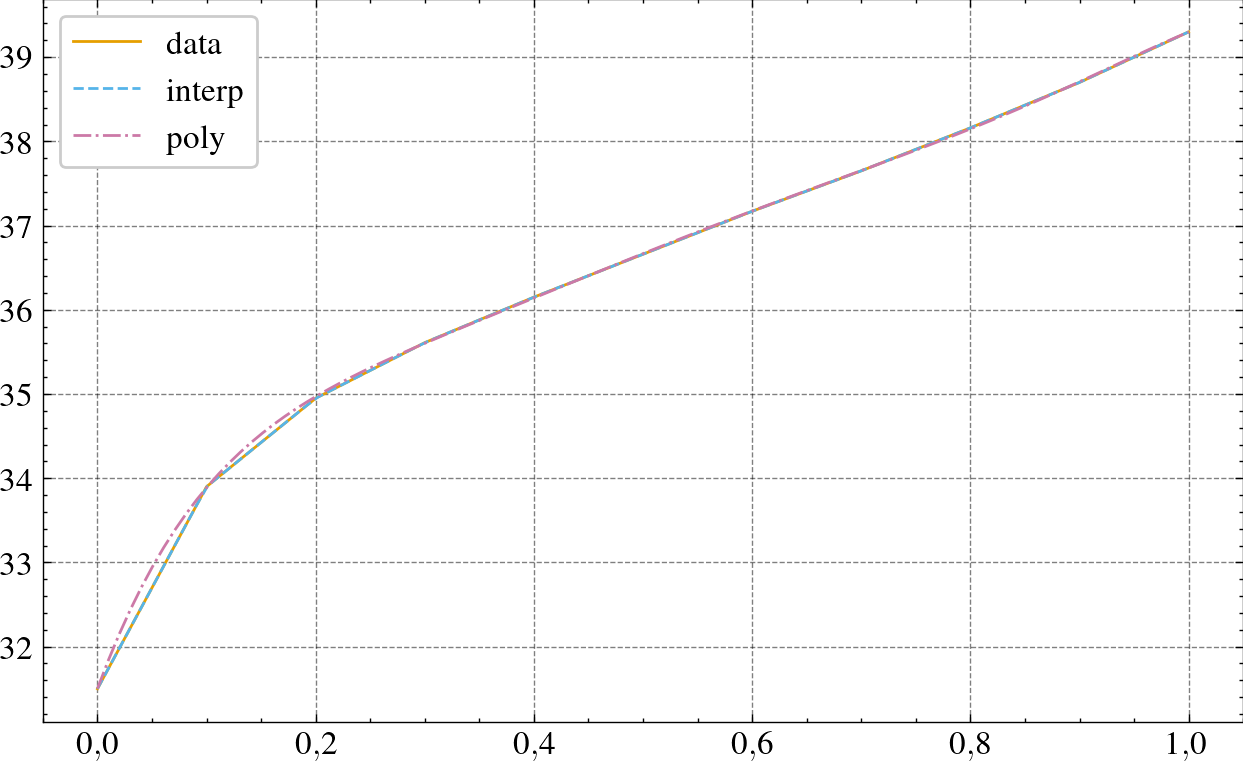

In [8]:
plt.figure()

# From: https://imgv2-2-f.scribdassets.com/img/document/682244176/original/0a169c4659/1730632177?v=1
ocv = (np.array([13.1, 12.9, 12.72, 12.55, 12.39, 12.22, 12.05, 11.87, 11.65, 11.3, 10.5]) * 3)[::-1]
soc = np.array([1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0])[::-1]
plt.plot(soc, ocv, label='data')

soc_test = np.linspace(0, 1, 100)

original_ocv_coeffs = [ocv[0], *(ocv / ocv[0])]
ocv_interp = np.array([original_ocv_coeffs[0]*lut_interp(original_ocv_coeffs[1:], soc) for soc in soc_test])
plt.plot(soc_test, ocv_interp, label='interp')

deg = 6
batt_k_V_OC_coeffs = np.polynomial.Polynomial.fit(soc, ocv, deg, [0, 1]).convert().coef
display(batt_k_V_OC_coeffs)

ocv_poly = np.polynomial.Polynomial(batt_k_V_OC_coeffs)(soc_test)
plt.plot(soc_test, ocv_poly, label='poly')

plt.legend()
plt.show()

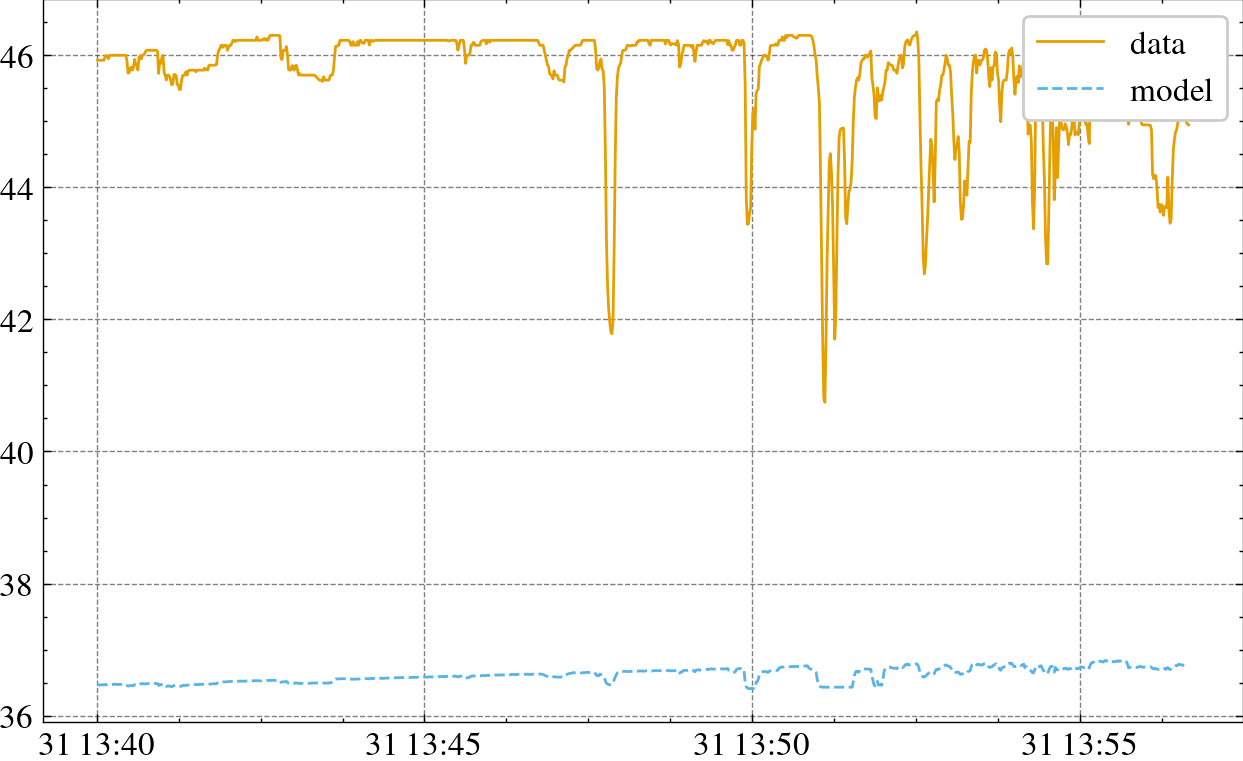

In [9]:
batt_name = 'D35'
cell_amps_hour = 48
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q = parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
initial_SOC = 1
nominal_voltage = series_cells * cell_voltage

battery_params = {
    'batt_eta': 1,
    'batt_Q': cell_amps_hour * 3600,
    'batt_k_V_OC_coeffs': original_ocv_coeffs,
    'batt_R_0_coeffs': [0.01, 1],
    'batt_R_1_coeffs': [0.01, 1],
    'batt_C_1_coeffs': [100, 1],
}

# Select the optimization data
data_cols = ['batt_v']
input_cols = ['batt_i']

df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols][:1000]

# Time array
T = df_train['t'].to_numpy()

# Inputs
U = df_train[['batt_i']].to_numpy().T

# Model
battery = Battery.build(battery_params)

# Initial state
X0 = Battery.initial_state(X0={'batt_z': 0.4}, U0=U[:,0], params=battery_params)

# Simulation
res = ct.input_output_response(battery, T=T, U=U, X0=X0, solve_ivp_method='Radau')
ydata = res.to_pandas().set_index('time')[res.output_labels]

plt.plot(df_train.index, df_train['batt_v'], label='data')
plt.plot(df_train.index, ydata['batt_v'], label='model')
plt.legend(loc='upper right')
plt.show()

# Optimization

In [10]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.nelder import NelderMead
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.isres import ISRES
from pymoo.algorithms.soo.nonconvex.es import ES
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
from pymoo.algorithms.soo.nonconvex.pattern import PatternSearch
from pymoo.operators.sampling.lhs import LHS
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.parallelization.starmap import StarmapParallelization
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool

def model_function(T, U, X0, **params):
    return ct.input_output_response(
        Battery.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='LSODA',
    ).to_pandas()

In [11]:
battery_params

{'batt_eta': 1,
 'batt_Q': 172800,
 'batt_k_V_OC_coeffs': [31.5,
  1.0,
  1.0761904761904764,
  1.1095238095238096,
  1.1304761904761904,
  1.1476190476190478,
  1.1638095238095238,
  1.1800000000000002,
  1.1952380952380954,
  1.2114285714285715,
  1.2285714285714286,
  1.2476190476190476],
 'batt_R_0_coeffs': [0.01, 1],
 'batt_R_1_coeffs': [0.01, 1],
 'batt_C_1_coeffs': [100, 1]}

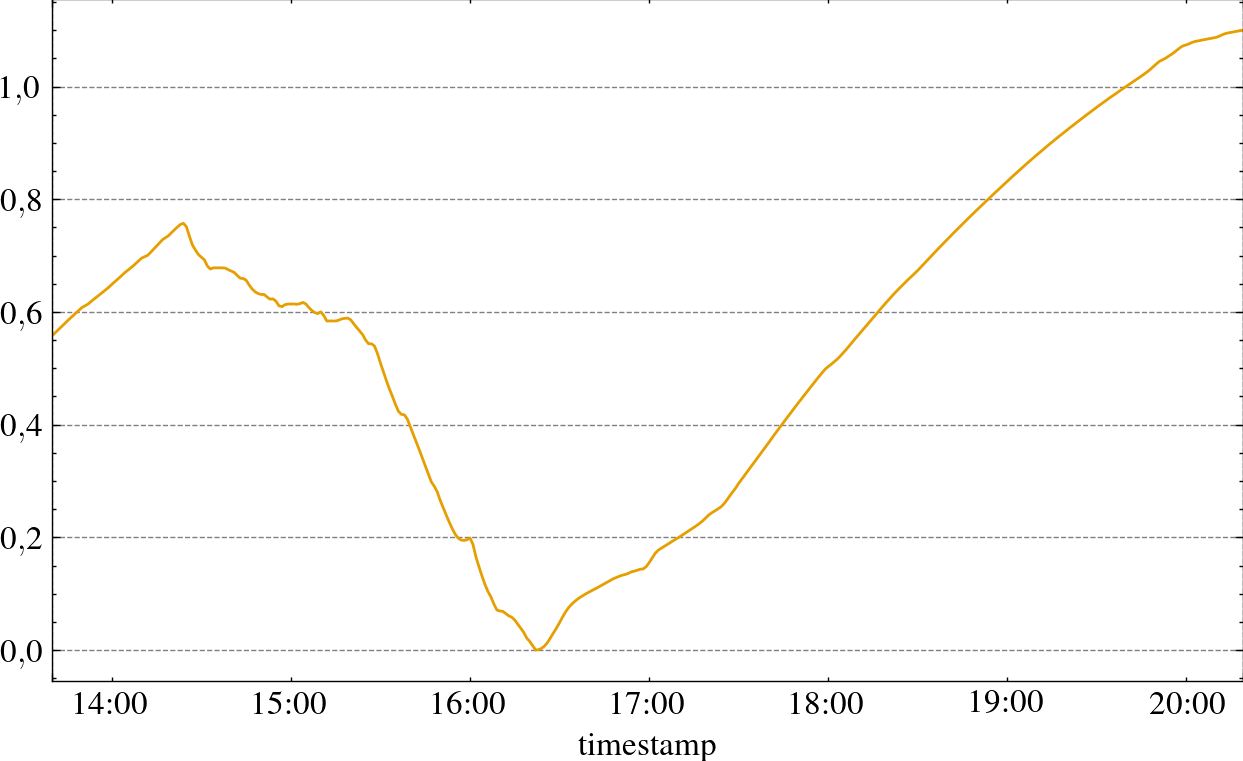

In [12]:
df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols].resample('1min').mean().interpolate(method='time')
compute_df_capacity(df_train, nominal_Q, initial_SOC, inplace=True)
compute_df_soc(df_train, nominal_Q, inplace=True)
# df_train['batt_z'] = (df_train['batt_z'] - df_train['batt_z'].min()) / (df_train['batt_z'].max() - df_train['batt_z'].min())
df_train['batt_z'] = df_train['batt_z'] - df_train['batt_z'].min()
df_train['batt_z'].plot()
plt.show()

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      490 |  1.991435E+03 |  1.1380105456
     2 |      980 |  1.154012E+03 |  1.1380105456
     3 |     1470 |  6.558861E+02 |  1.1380105456
     4 |     1960 |  3.308931E+02 |  1.0607326711
     5 |     2450 |  1.796547E+02 |  0.5612293360
     6 |     2940 |  9.234429E+01 |  0.0813640735
     7 |     3430 |  4.912799E+01 |  0.0813640735
     8 |     3920 |  2.761229E+01 |  0.0813640735
     9 |     4410 |  1.362238E+01 |  0.0813640735
    10 |     4900 |  6.7745295080 |  0.0813640735
    11 |     5390 |  3.3159568198 |  0.0285902959
    12 |     5880 |  1.5973735113 |  0.0285902959
    13 |     6370 |  0.8605119841 |  0.0285902959
    14 |     6860 |  0.5192032038 |  0.0285902959
    15 |     7350 |  0.3507824955 |  0.0285902959
    16 |     7840 |  0.2613466189 |  0.0148388406
    17 |     8330 |  0.1978457702 |  0.0148388406
    18 |     8820 |  0.1504792063 |  0.0148388406
    19 |     9310 |  0.1153584301 |  0.0148388406


{'batt_eta': 1,
 'batt_C_1_coeffs': [100, 1],
 'batt_R_0_coeffs': [0.01, 1],
 'batt_R_1_coeffs': [0.01, 1],
 'batt_k_V_OC_coeffs': [31.5,
  1.0,
  1.0761904761904764,
  1.1095238095238096,
  1.1304761904761904,
  1.1476190476190478,
  1.1638095238095238,
  1.1800000000000002,
  1.1952380952380954,
  1.2114285714285715,
  1.2285714285714286,
  1.2476190476190476]}

Best parameters found:


{'batt_eta': 0.1691266719562577,
 'batt_C_1_coeffs': [1093.257380255017,
  93.33202102536531,
  84.57664723570306,
  7.531456680622067,
  5.789942733080813,
  2.9195422289501862,
  31.816423892265185,
  2.055584729503944,
  18.23073826563392,
  56.33017836340016,
  6.756111443001968,
  74.49633931505095],
 'batt_R_0_coeffs': [0.016016189303267845,
  73.02303676394868,
  36.32793710710604,
  93.92019123681807,
  25.86320693354993,
  18.27141083455392,
  1.8965320532840766,
  4.840652422850658,
  99.4536832583204,
  14.48834285000753,
  57.15762215940401,
  38.27442928835718],
 'batt_R_1_coeffs': [0.014860684776370295,
  53.82789057994919,
  8.520267215532522,
  64.39863473175127,
  3.4398663585211144,
  53.72557249347394,
  68.14065592792048,
  15.263556704544824,
  28.48844059803295,
  82.08418727778358,
  19.33589919527227,
  89.76680034858377],
 'batt_k_V_OC_coeffs': [35.886561999770294,
  0.8540842420121599,
  0.8565674056058313,
  0.8259880166425098,
  1.051008009389049,
  0.829966

Objective value at solution: [0.00113785]


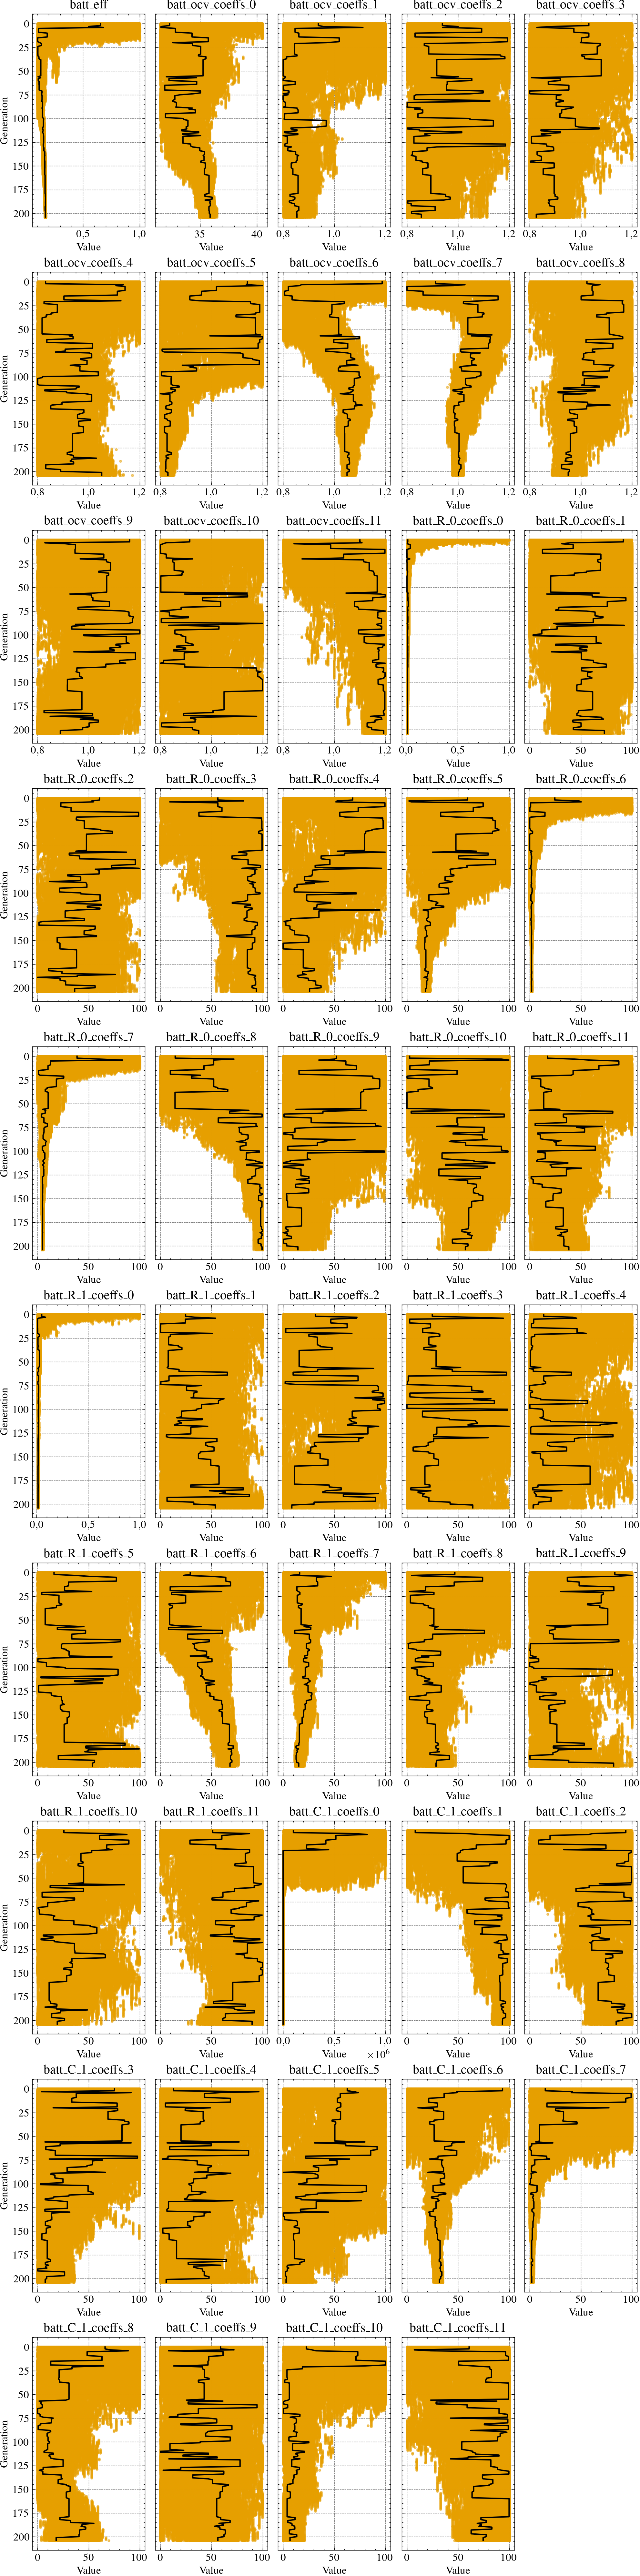

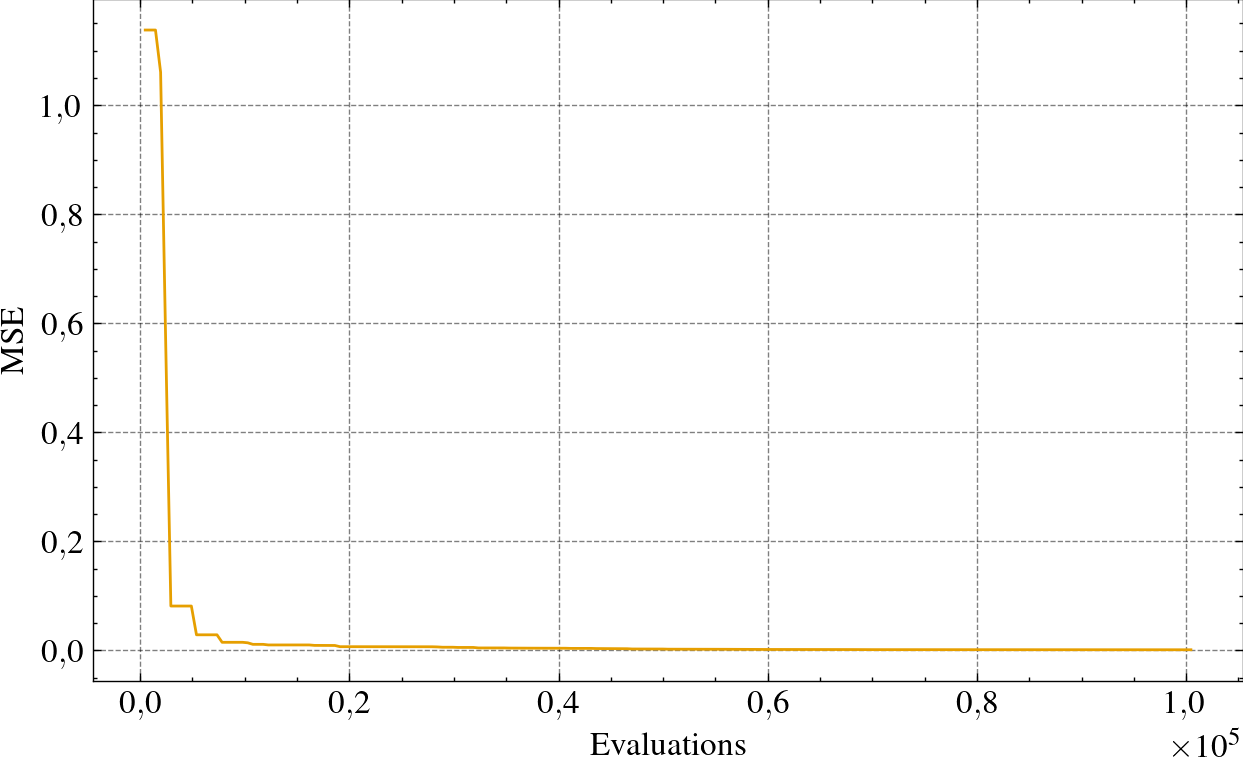

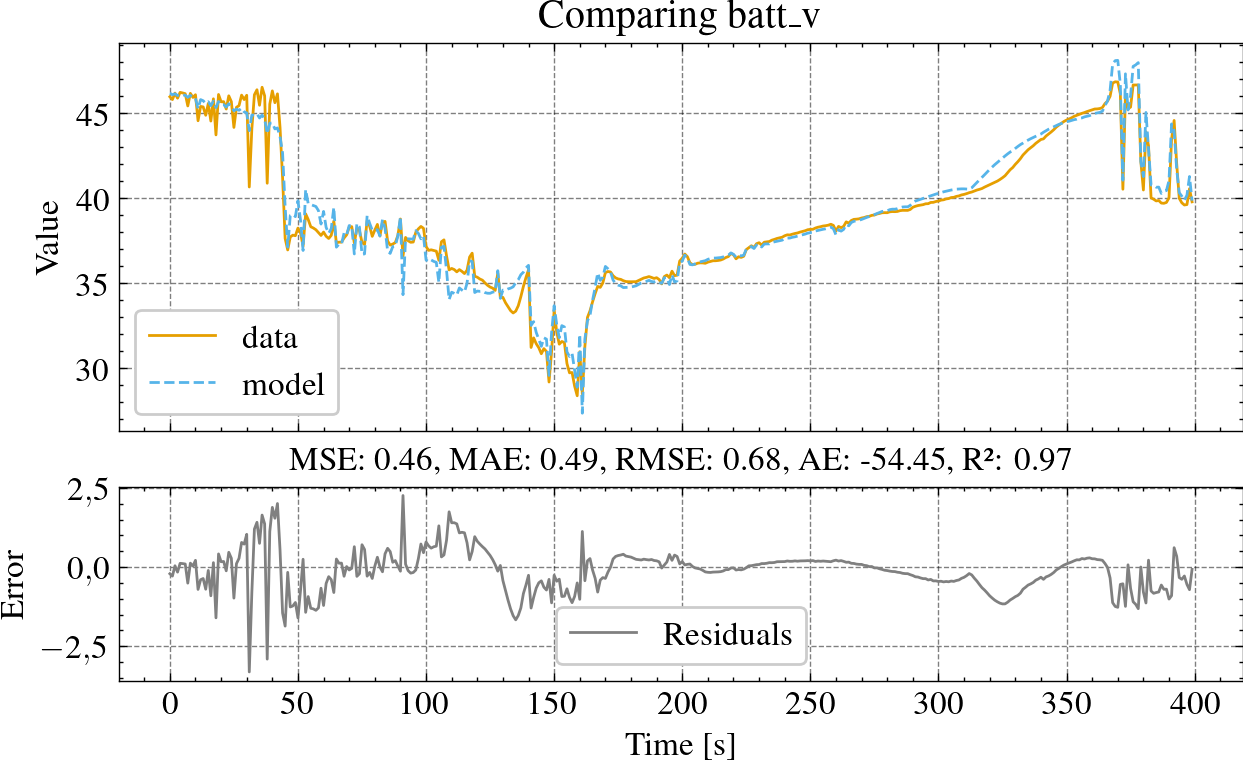

CPU times: user 24.2 s, sys: 2.99 s, total: 27.2 s
Wall time: 1min 29s


In [13]:
%%time
## BATTERY OPTIMIZATION

# Select the optimization data
# data_cols = ['batt_v', 'batt_z']
data_cols = ['batt_v']
input_cols = ['batt_i']

# Put simulation data into df
# df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols]
df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols].resample('1min').mean().interpolate(method='time')
compute_df_capacity(df_train, nominal_Q, initial_SOC, inplace=True)
compute_df_soc(df_train, nominal_Q, inplace=True)
# df_train['batt_z'] = (df_train['batt_z'] - df_train['batt_z'].min()) / (df_train['batt_z'].max() - df_train['batt_z'].min())
df_train['batt_z'] = df_train['batt_z'] - df_train['batt_z'].min()

# Set model states initial conditions
batt_z_0 = df_train['batt_z'][0]
input_initial_state = {'batt_z': batt_z_0}

# Initialize Parameters
params_bounds = {
    'batt_eta': dict(min=0.1, max=1),
}
lut_coeffs = [
    {'name': 'batt_k_V_OC_coeffs', 'n_coeffs': 12, 'bounds': (series_cells*10.5, series_cells*13.5), 'var': (0.8, 1.2)},
    {'name': 'batt_R_0_coeffs', 'n_coeffs': 12, 'bounds': (0.01, 1), 'var': (0.01, 100)},
    {'name': 'batt_R_1_coeffs', 'n_coeffs': 12, 'bounds': (0.01, 1), 'var': (0.01, 100)},
    {'name': 'batt_C_1_coeffs', 'n_coeffs': 12, 'bounds': (1e3, 1e6), 'var': (0.01, 100)},
]
for coeff in lut_coeffs:
    name = coeff['name']
    coeff_bounds = coeff['bounds']
    var_bounds = coeff['var']
    n_coeffs = coeff['n_coeffs']
    for i in range(0, n_coeffs):
        if i == 0:
            params_bounds[f'{name}_{i}'] = dict(min=coeff_bounds[0], max=coeff_bounds[1])
        else:
            params_bounds[f'{name}_{i}'] = dict(min=var_bounds[0], max=var_bounds[1])

# Initialize the thread pool and create the runner
n_processes = 32
pool = Pool(processes=n_processes)
runner = StarmapParallelization(pool.starmap)

# Initialize the problem
model = Battery
model_params = battery_params
problem = MyOptimizationProblem(
    model=model,
    model_function=model_function,
    training_data=df_train,
    training_data_columns=data_cols,
    model_params=model_params,
    opt_params_bounds=params_bounds,
    input_initial_state=input_initial_state,
    input_columns=input_cols,
    data_scaler=MinMaxScaler,
    elementwise_runner=runner,
)

algorithm = DE(
    pop_size=10*len(params_bounds),
    sampling=LHS(),
    variant="DE/rand/1/bin",
    F=0.2,
    CR=0.9,
)

# Specify termination criteria (optional)
termination = DefaultSingleObjectiveTermination(
    xtol=1e-8,
    cvtol=1e-6,
    ftol=1e-6,
    period=20,
    n_max_gen=1000,
    n_max_evals=100000
)

# Run the optimization
result = minimize(
    problem,
    algorithm,
    termination=termination,
    seed=42,
    verbose=True,
    save_history=True,
)
print('Threads:', result.exec_time)
pool.close()
pool.join()

# Print the results
best_params = convert_to_model_params({k: result.X[i] for (i, k) in enumerate(params_bounds.keys())})
original_params = {k: convert_to_model_params(model_params)[k] for k in best_params.keys()}
print("Original parameters were:")
display(original_params)
print("Best parameters found:")
display(best_params)
print("Objective value at solution:", result.F)

plot_optimization_params(result, params_bounds)
plot_optimization_error(result, params_bounds)

T = df_train['t'].to_numpy()
U = df_train[input_cols].to_numpy().T
X0 = Battery.initial_state(X0={'batt_z': batt_z_0}, U0=U[:,0], params=model_params | best_params)

best_fit_data = model_function(T, U, X0, **(model_params | best_params))

for col in data_cols:
    plot_compare(df_train, best_fit_data, col)

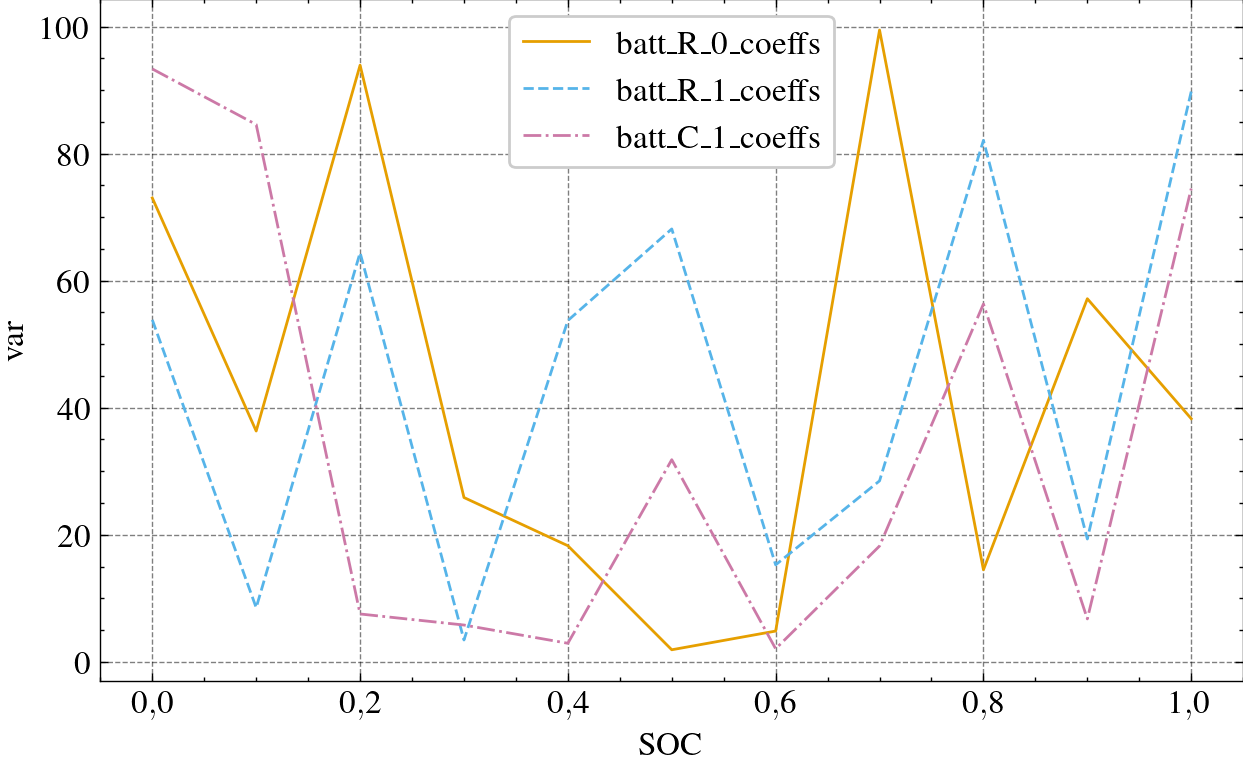

In [14]:
plt.figure()
plt.plot(np.linspace(0, 1, len(best_params['batt_R_0_coeffs']) -1), best_params['batt_R_0_coeffs'][1:], label='batt_R_0_coeffs')
plt.plot(np.linspace(0, 1, len(best_params['batt_R_1_coeffs']) -1), best_params['batt_R_1_coeffs'][1:], label='batt_R_1_coeffs')
plt.plot(np.linspace(0, 1, len(best_params['batt_C_1_coeffs']) -1), best_params['batt_C_1_coeffs'][1:], label='batt_C_1_coeffs')
plt.ylabel('var')
plt.xlabel('SOC')
plt.legend()
plt.show()

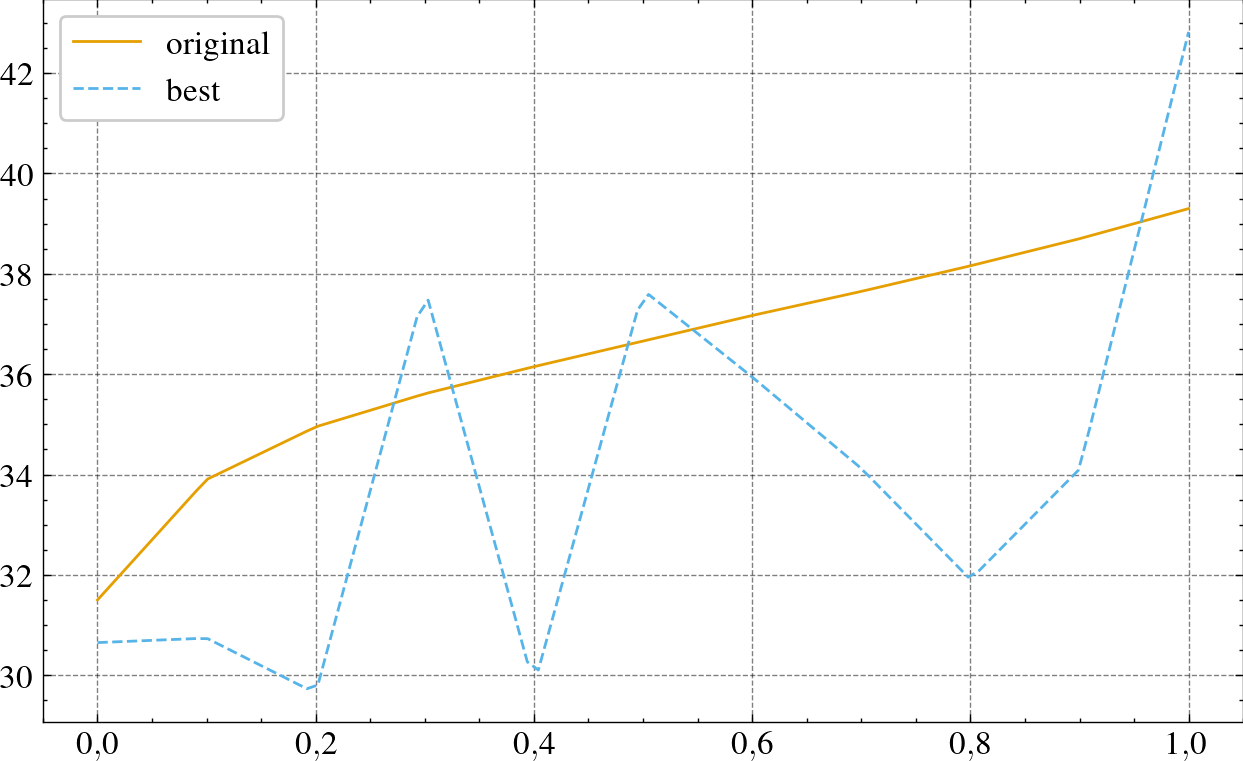

In [15]:
if 'batt_k_V_OC_coeffs' in best_params:
    soc_test = np.linspace(0, 1, 100)
    ocv_ref = np.array([original_ocv_coeffs[0]*lut_interp(original_ocv_coeffs[1:], soc) for soc in soc_test])
    plt.plot(soc_test, ocv_ref, label='original')

    best_ocv_coeffs = best_params['batt_k_V_OC_coeffs']
    ocv_ref = np.array([best_ocv_coeffs[0]*lut_interp(best_ocv_coeffs[1:], soc) for soc in soc_test])
    plt.plot(soc_test, ocv_ref, label='best')
    plt.legend()
    plt.show()

In [16]:
%%time

import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.termination import get_termination
from pymoo.core.evaluator import Evaluator
from pymoo.parallelization.starmap import StarmapParallelization
from sklearn.metrics import mean_squared_error
import multiprocessing

class BattZOptimization(ElementwiseProblem):
    def __init__(self, section, df, nominal_Q, model_params, best_params, data_cols, input_cols, **kwargs):
        super().__init__(n_var=1, n_obj=1, n_constr=0, xl=np.array([0]), xu=np.array([1]), **kwargs)
        self.section = section
        self.df = df
        self.nominal_Q = nominal_Q
        self.model_params = model_params
        self.best_params = best_params
        self.data_cols = data_cols
        self.input_cols = input_cols

    def _evaluate(self, x, out, *args, **kwargs):
        batt_z_0 = x[0]

        df_test = self.df.loc[
            (self.df.index >= self.section['start']) & (self.df.index <= self.section['end']),
            ['t'] + self.data_cols + self.input_cols
        ].dropna().resample('1min').mean().interpolate(method='time')

        if df_test.empty:
            out["F"] = np.inf
            return

        compute_df_capacity(df_test, self.nominal_Q, batt_z_0, inplace=True)
        compute_df_soc(df_test, self.nominal_Q, inplace=True)

        T = df_test['t'].to_numpy()
        U = df_test[self.input_cols].to_numpy().T

        X0 = Battery.initial_state(X0={'batt_z': df_test['batt_z'][0]}, U0=U[:, 0], params=self.model_params | self.best_params)
        df_pred = model_function(T, U, X0, **(self.model_params | self.best_params))

        out["F"] = mean_squared_error(df_test[self.data_cols].values, df_pred[self.data_cols].values)

# Create a parallel processing pool
n_processes = 32
pool = Pool(processes=n_processes)
runner = StarmapParallelization(pool.starmap)

# Run optimization for each section
batt_z_0_dict = {}
for section in sections.reset_index().to_dict(orient='records'):
    section_name = section['name'].replace('Section ', '')

    problem = BattZOptimization(
        section, df, nominal_Q, model_params, best_params, data_cols, input_cols, elementwise_runner=runner,
    )

    algorithm = DE(
        pop_size=10,
        sampling=LHS(),
        variant="DE/rand/1/bin",
        F=0.2,
        CR=0.9,
    )

    termination = DefaultSingleObjectiveTermination(
        xtol=1e-8,
        cvtol=1e-6,
        ftol=1e-6,
        period=20,
        n_max_gen=10000,
        n_max_evals=100000
    )

    res = minimize(problem, algorithm, termination=termination, seed=42, verbose=True, save_history=True)

    batt_z_0_dict[section_name] = res.X[0]

    print(f'Optimized batt_z_0 for {section_name}: {res.X[0]}')

pool.close()
pool.join()

print("Final batt_z_0_dict:", batt_z_0_dict)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 |  2.206758E+02 |  1.539569E+01
     2 |       20 |  1.089907E+02 |  7.2339411451
     3 |       30 |  6.150408E+01 |  7.2339411451
     4 |       40 |  3.993820E+01 |  7.2339411451
     5 |       50 |  3.325780E+01 |  4.2860994220
     6 |       60 |  2.471583E+01 |  2.0829880429
     7 |       70 |  1.233518E+01 |  0.5528052707
     8 |       80 |  4.8497074783 |  0.5528052707
     9 |       90 |  3.2115136020 |  0.3978205578
    10 |      100 |  2.4145911516 |  0.3978205578
    11 |      110 |  0.6615990648 |  0.3978205578
    12 |      120 |  0.5684903329 |  0.3978205578
    13 |      130 |  0.5218515824 |  0.3953575763
    14 |      140 |  0.5218515824 |  0.3953575763
    15 |      150 |  0.5049120221 |  0.3953575763
    16 |      160 |  0.4436586831 |  0.3953575763
    17 |      170 |  0.4415547176 |  0.3953575763
    18 |      180 |  0.4227210961 |  0.3952011371
    19 |      190 |  0.4045832567 |  0.3947406083


{'D': 0.5580626024631437, 'E': 0.5746325168707549, 'F': 0.5351240782176889, 'F1': 0.5580487816370483, 'F2': 0.4979556339039592}
/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_d.pdf


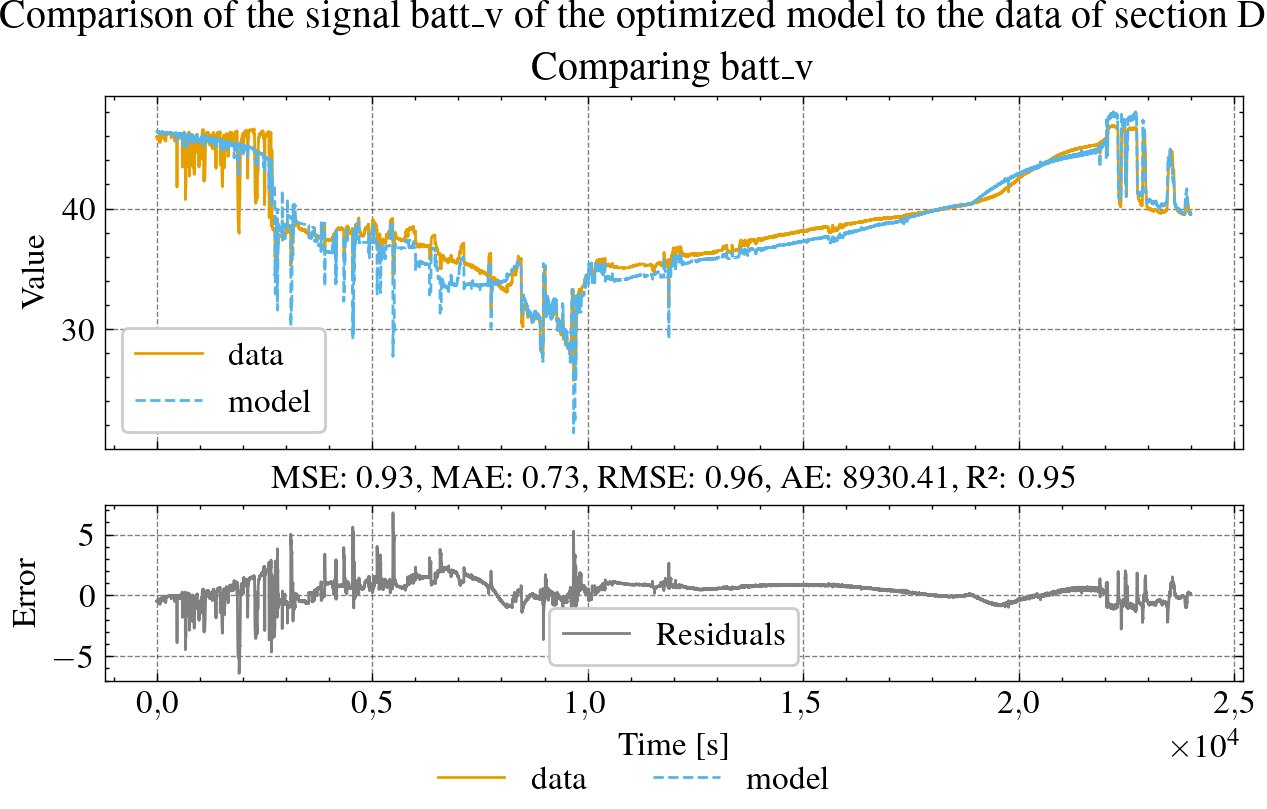

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_e.pdf


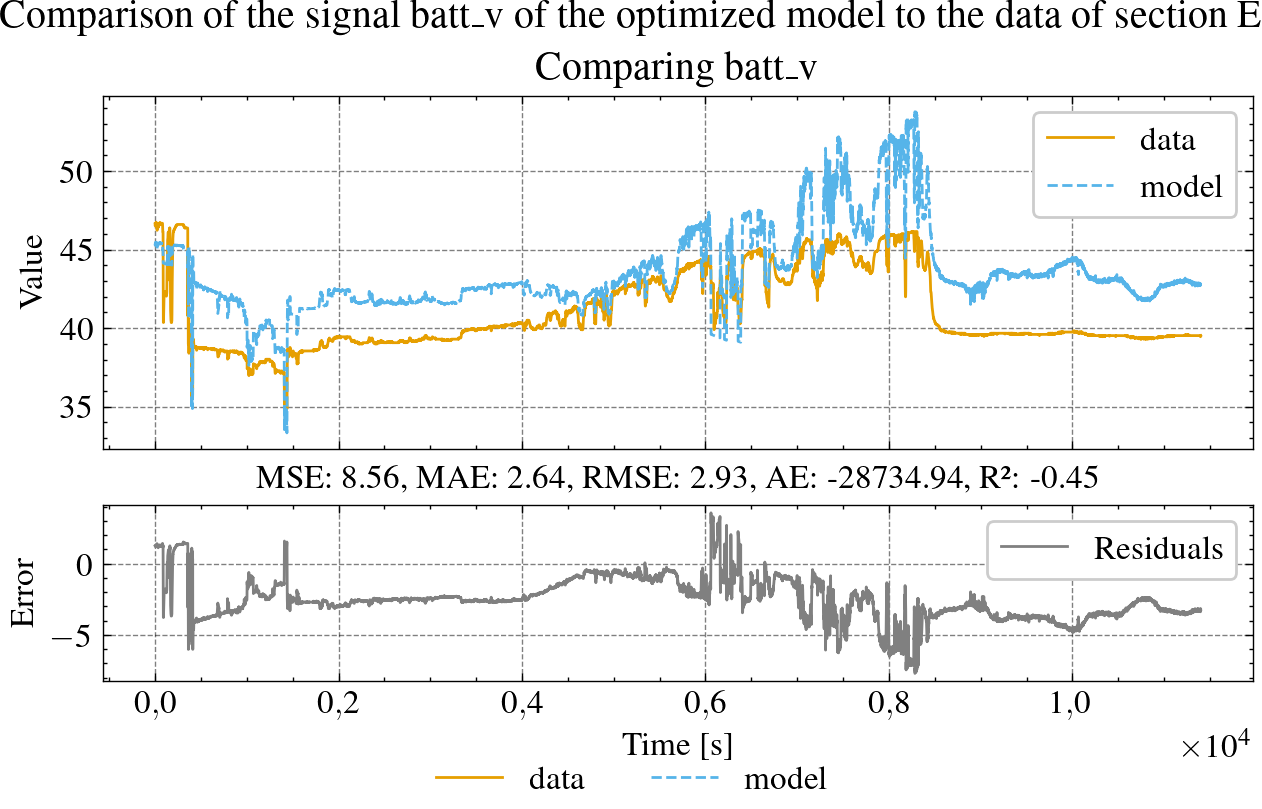

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_f.pdf


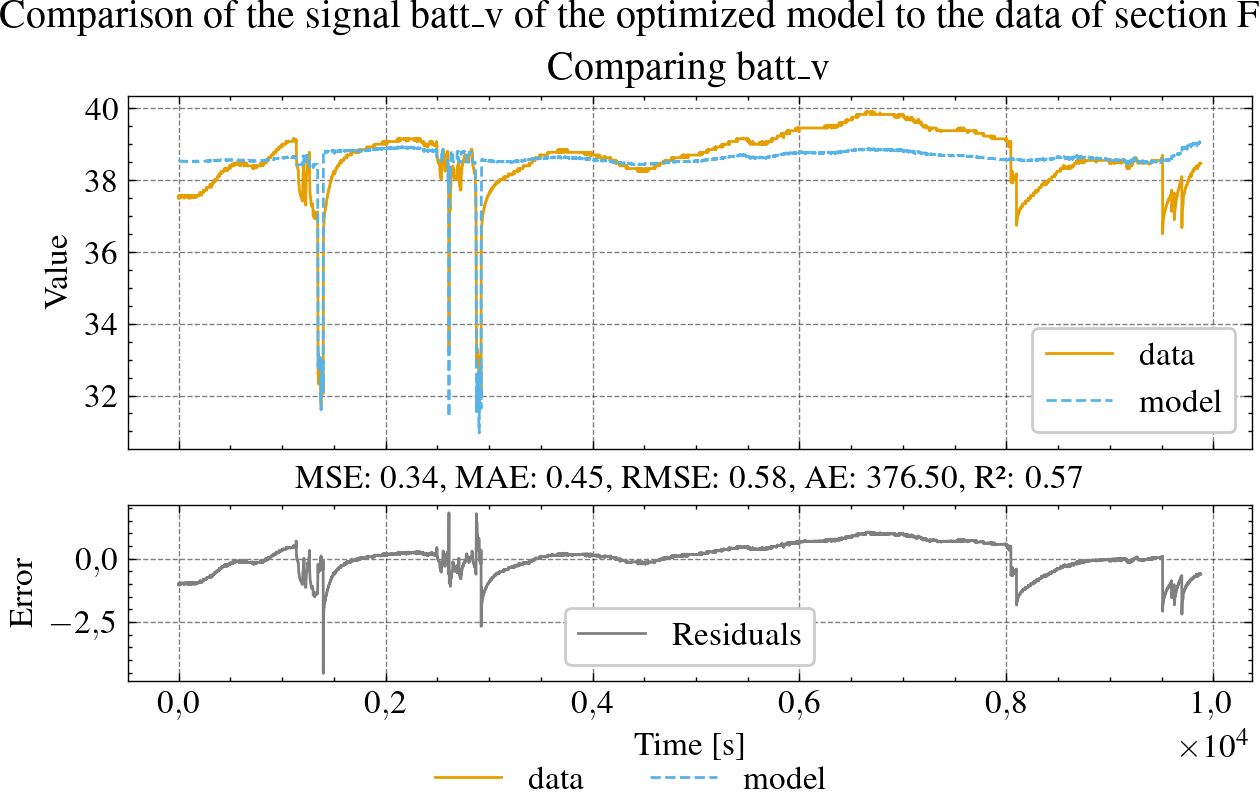

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_f1.pdf


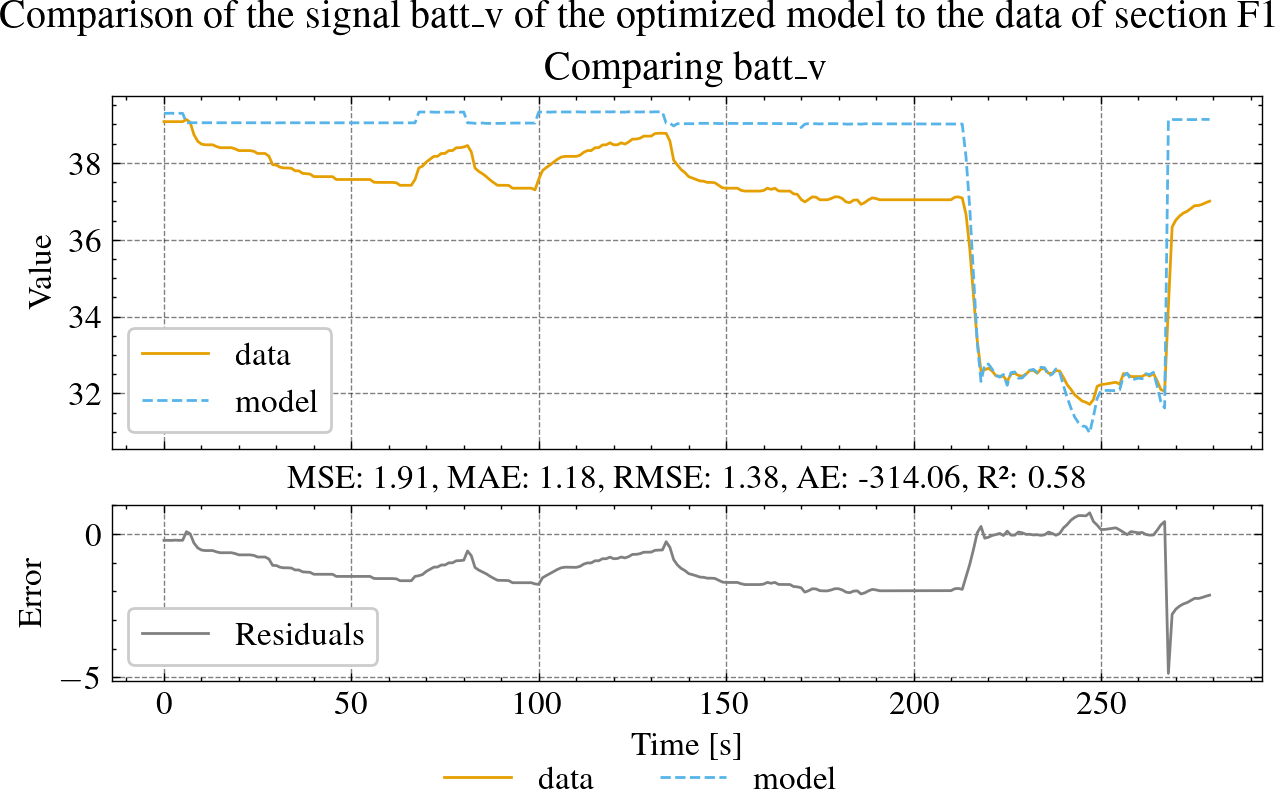

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_f2.pdf


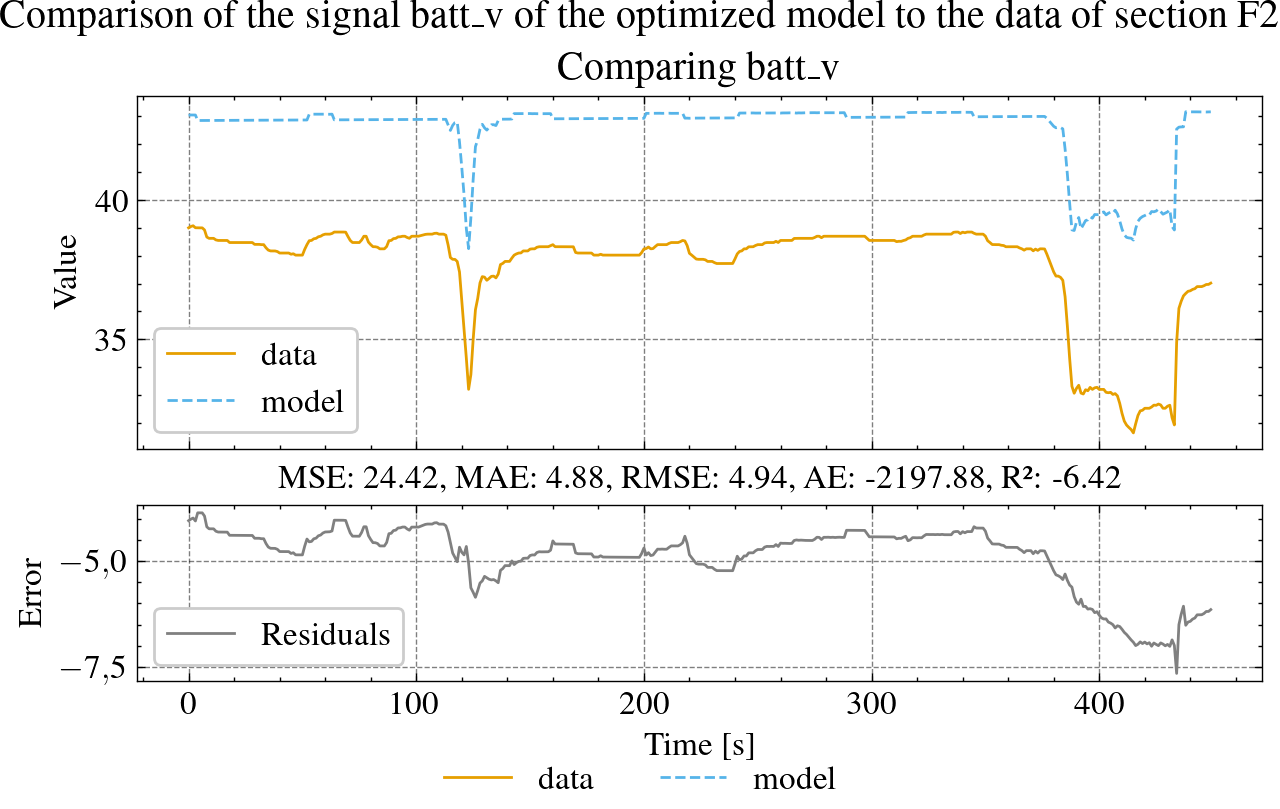

In [17]:
print(batt_z_0_dict)

for section in sections.reset_index().to_dict(orient='records'):
    section_name = section['name'].replace('Section ', '')
    batt_z_0 = batt_z_0_dict[section_name]

    df_test = df.loc[(df.index >= section['start']) & (df.index <= section['end']), ['t'] + data_cols + input_cols].dropna()
    if df_test.size == 0:
        print('Ignoring section', section_name, ' because of insufficient size')
        continue
    compute_df_capacity(df_test, nominal_Q, batt_z_0, inplace=True)
    compute_df_soc(df_test, nominal_Q, inplace=True)
    batt_z_0 = df_test['batt_z'][0]

    T = df_test['t'].to_numpy()
    U = df_test[input_cols].to_numpy().T
    X0 = Battery.initial_state(X0={'batt_z': batt_z_0}, U0=U[:,0], params=model_params | best_params)

    df_pred = model_function(T, U, X0, **(model_params | best_params))

    # Plot comparison for each data column
    for col in data_cols:
        filename = f'{latex_img_path}/battery_optimization_test_residuals_{col}_test_{section_name.lower()}.pdf'
        print(filename)
        fig_save_and_show(
            filename=filename,
            show_title=f'Comparison of the signal {col} of the optimized model to the data of section {section_name}',
            save_title=f'Comparação do sinal {col} do modelo otimizado com os dados da seção {section_name}',
            ncol=2,
            fig=plot_compare(df_test, df_pred, col, show=False),
        )
